In [2]:
# Import necessary libraries
import yfinance
import math                 # For mathematical operations
import numpy as np          # For numerical operations
import pandas as pd         # For data manipulation and analysis
import seaborn as sns       # For data visualization
sns.set_style('whitegrid')  # Set seaborn style to whitegrid
import matplotlib.pyplot as plt  # For plotting graphs
plt.style.use("fivethirtyeight")  # Use 'fivethirtyeight' style for matplotlib plots

# Importing Keras libraries for building neural network models
import keras
from keras.models import Sequential  # For sequential model building
from keras.callbacks import EarlyStopping  # For early stopping during model training
from keras.layers import Dense, LSTM, Dropout  # For adding layers to neural network model

# Importing Scikit-learn libraries for data preprocessing and model evaluation
from sklearn.preprocessing import MinMaxScaler  # For data normalization
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.metrics import mean_squared_error, mean_absolute_error  # For model evaluation

import warnings   # For handling warnings
warnings.simplefilter('ignore')   # Ignore warnings for cleaner output

In [3]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol for Bitcoin
ticker_symbol = "BTC-USD"

# Fetch data
btc_data = yf.download(ticker_symbol, period="max", interval="1d")

# Display the first few rows of the dataframe
btc_data.head()


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


# Normalizing Data

In [5]:
# Grouping the data by date and calculating the mean closing price for each date
df_close = btc_data.groupby('Date')['Close'].mean()

# Creating a DataFrame from the calculated mean closing prices
df_close = pd.DataFrame(df_close)

In [6]:
# Importing MinMaxScaler from sklearn.preprocessing module
from sklearn.preprocessing import MinMaxScaler

# Creating a MinMaxScaler object with feature range scaled between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshaping the closing price values into a 2D array and scaling the data
scaled_data = scaler.fit_transform(np.array(df_close.values).reshape(-1, 1))

# Splitting Data

In [7]:
# Splitting the data into training and testing sets
# 75% of the data for training, 25% for testing
train_size = int(len(df_close) * 0.75)
test_size = len(df_close) - train_size

# Printing the sizes of the training and testing sets
print("Train Size:", train_size, "Test Size:", test_size)

# Extracting the training and testing data from the scaled data
# For training data, select the first 'train_size' elements
train_data = scaled_data[:train_size, 0:1]
# For testing data, select 'test_size' elements starting from 'train_size - 60'
test_data = scaled_data[train_size - 60:, 0:1]

Train Size: 2627 Test Size: 876


In [8]:
# Checking the shapes of the training and testing data arrays
# This provides information about the dimensions of the arrays
train_data.shape, test_data.shape

((2627, 1), (936, 1))

Traning set

In [9]:
# Creating a Training set with 60 time-steps and 1 output
x_train = []  # List to store input sequences
y_train = []  # List to store output values

# Iterating over the training data to create input-output pairs
# Each input sequence contains 60 time-steps, and the corresponding output is the next time-step value
for i in range(60, len(train_data)):
    # Extracting input sequence of length 60 and appending it to x_train
    x_train.append(train_data[i - 60:i, 0])
    # Extracting the output value (next time-step) and appending it to y_train
    y_train.append(train_data[i, 0])

In [10]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [11]:
# Reshaping the input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [12]:
# Checking the shapes of the training input and output arrays
# This provides information about the dimensions of the arrays
x_train.shape, y_train.shape

((2567, 60, 1), (2567,))

# LSTM Model

In [13]:
# Define the LSTM model architecture
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),  # LSTM layer with 50 units, returns sequences, input shape: (sequence length, features)
    LSTM(64, return_sequences=False),  # LSTM layer with 64 units, does not return sequences
    Dense(32),  # Fully connected (dense) layer with 32 units
    Dense(16),  # Fully connected (dense) layer with 16 units
    Dense(1)    # Output layer with 1 unit (for regression)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=["mean_absolute_error"])

In [14]:
# Display a summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 42,465
Trainable params: 42,465
Non-trainable params: 0
_________________________________________________________________


## Train Model

In [15]:
# Fit the LSTM model to the training set
# Early stopping callback is used to stop training if the loss stops decreasing
callbacks = [EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]

# Fit the model to the training data
# Number of epochs is set to 100, and batch size is set to 32
history = model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks=callbacks)

Epoch 1/100
81/81 [==============================] - 9s 15ms/step - loss: 0.0049 - mean_absolute_error: 0.0331
Epoch 2/100
81/81 [==============================] - 1s 13ms/step - loss: 6.6717e-04 - mean_absolute_error: 0.0132
Epoch 3/100
81/81 [==============================] - 1s 13ms/step - loss: 5.4290e-04 - mean_absolute_error: 0.0133
Epoch 4/100
81/81 [==============================] - 1s 13ms/step - loss: 4.7807e-04 - mean_absolute_error: 0.0128
Epoch 5/100
81/81 [==============================] - 1s 13ms/step - loss: 4.0694e-04 - mean_absolute_error: 0.0115
Epoch 6/100
81/81 [==============================] - 1s 13ms/step - loss: 4.5599e-04 - mean_absolute_error: 0.0124
Epoch 7/100
81/81 [==============================] - 1s 13ms/step - loss: 3.2663e-04 - mean_absolute_error: 0.0097
Epoch 8/100
81/81 [==============================] - 1s 13ms/step - loss: 3.0678e-04 - mean_absolute_error: 0.0103
Epoch 9/100
81/81 [==============================] - 1s 13ms/step - loss: 3.5248e-04

## Evaluation

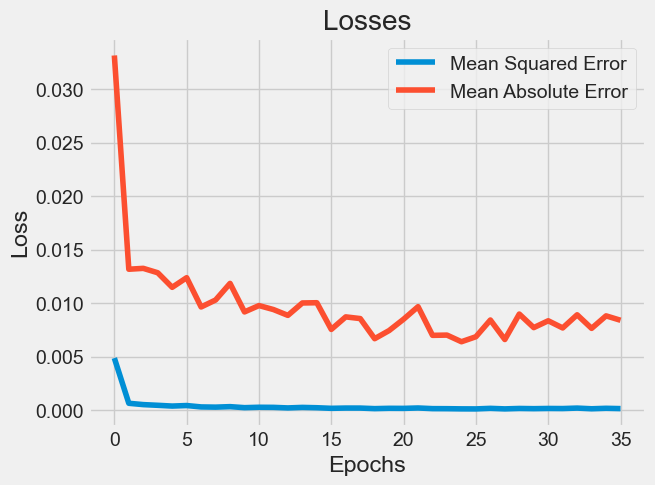

In [17]:
# Plotting the training losses over epochs
plt.plot(history.history["loss"])  # Plot mean squared error loss
plt.plot(history.history["mean_absolute_error"])  # Plot mean absolute error
plt.legend(['Mean Squared Error', 'Mean Absolute Error'])  # Add legend
plt.title("Losses")  # Set title
plt.xlabel("Epochs")  # Set x-axis label
plt.ylabel("Loss")  # Set y-axis label
plt.show()  # Show the plot

# Predection

Create test set

In [18]:
# Creating a testing set with 60 time-steps and 1 output
x_test = []  # Initialize list for input sequences
y_test = []  # Initialize list for output values

# Loop through the test data to create input-output pairs
for i in range(60, len(test_data)):
    # Append the previous 60 time-steps as input
    x_test.append(test_data[i-60:i, 0])
    # Append the next time-step as the output
    y_test.append(test_data[i, 0])

# Convert lists to numpy arrays
x_test, y_test = np.array(x_test), np.array(y_test)

# Reshape input data to match the input shape expected by the model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [19]:
x_test.shape , y_test.shape

((876, 60, 1), (876,))

In [20]:
# Perform inverse scaling on the predicted values to obtain actual values
predictions = model.predict(x_test)

# Inverse scaling of the predictions to obtain actual values
predictions = scaler.inverse_transform(predictions)

# Check the shape of the predictions
predictions.shape

28/28 [==============================] - 1s 9ms/step


(876, 1)

root mean squared error

In [21]:
# Inverse scaling on the test output data to obtain actual values
y_test = scaler.inverse_transform([y_test])

# Calculate the Root Mean Squared Error (RMSE) between actual and predicted values
RMSE = np.sqrt(np.mean( (y_test - predictions)**2 )).round(2)

# Print the RMSE value
RMSE

18407.22

In [22]:
# Check the shape of the predictions array
predictions.shape

(876, 1)

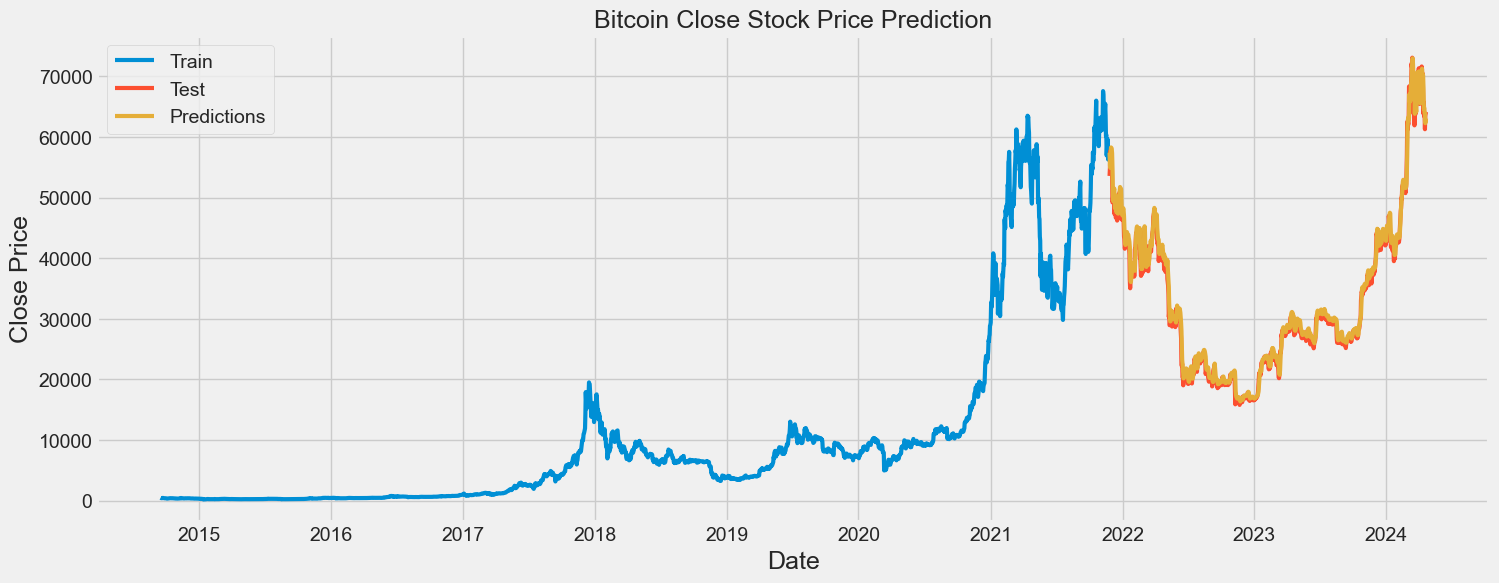

In [23]:
# Plotting the predicted and actual closing prices

# Extracting training and testing data
train = df_close.iloc[:train_size , 0:1]
test = df_close.iloc[train_size: , 0:1]

# Adding predictions to the testing data
test['Predictions'] = predictions

# Setting up the plot
plt.figure(figsize= (16, 6))
plt.title('Bitcoin Close Stock Price Prediction', fontsize= 18)
plt.xlabel('Date', fontsize= 18)
plt.ylabel('Close Price', fontsize= 18)

# Plotting the training, testing, and predicted closing prices
plt.plot(train['Close'], linewidth= 3)
plt.plot(test['Close'], linewidth= 3)
plt.plot(test["Predictions"], linewidth= 3)

# Adding legend
plt.legend(['Train', 'Test', 'Predictions'])

Forecaset next 30 days

In [27]:
# Importing the timedelta class from the datetime module
from datetime import timedelta

In [24]:
def insert_end(Xin, new_input):
    """
    Inserts a new input sequence at the end of the input array.

    Args:
    - Xin: Input array of shape (batch_size, timestep, features).
    - new_input: New input sequence to be inserted, with shape (batch_size, 1, features).

    Returns:
    - Xin: Updated input array with the new input sequence inserted at the end.
    """
    timestep = 60
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep - 1, :] = new_input
    return Xin

In [28]:
future = 30
forcast = []  # List to store forecasted values
Xin = x_test[-1 :, :, :]  # Initial input sequence for forecasting
time = []  # List to store future time steps

df_day = btc_data.groupby('Date')[['Open', 'Close', 'High', 'Low', 'Volume']].mean()

# Loop to forecast future values
for i in range(0, future):
    out = model.predict(Xin, batch_size=5)  # Predict next value
    forcast.append(out[0, 0])  # Append predicted value to forecast list
    Xin = insert_end(Xin, out[0, 0])  # Update input sequence for the next prediction
    time.append(pd.to_datetime(df_day.index[-1]) + timedelta(days=i))  # Append future time step

1/1 [==============================] - 0s 19ms/step


In [29]:
time

[Timestamp('2024-04-20 00:00:00'),
 Timestamp('2024-04-21 00:00:00'),
 Timestamp('2024-04-22 00:00:00'),
 Timestamp('2024-04-23 00:00:00'),
 Timestamp('2024-04-24 00:00:00'),
 Timestamp('2024-04-25 00:00:00'),
 Timestamp('2024-04-26 00:00:00'),
 Timestamp('2024-04-27 00:00:00'),
 Timestamp('2024-04-28 00:00:00'),
 Timestamp('2024-04-29 00:00:00'),
 Timestamp('2024-04-30 00:00:00'),
 Timestamp('2024-05-01 00:00:00'),
 Timestamp('2024-05-02 00:00:00'),
 Timestamp('2024-05-03 00:00:00'),
 Timestamp('2024-05-04 00:00:00'),
 Timestamp('2024-05-05 00:00:00'),
 Timestamp('2024-05-06 00:00:00'),
 Timestamp('2024-05-07 00:00:00'),
 Timestamp('2024-05-08 00:00:00'),
 Timestamp('2024-05-09 00:00:00'),
 Timestamp('2024-05-10 00:00:00'),
 Timestamp('2024-05-11 00:00:00'),
 Timestamp('2024-05-12 00:00:00'),
 Timestamp('2024-05-13 00:00:00'),
 Timestamp('2024-05-14 00:00:00'),
 Timestamp('2024-05-15 00:00:00'),
 Timestamp('2024-05-16 00:00:00'),
 Timestamp('2024-05-17 00:00:00'),
 Timestamp('2024-05-

In [30]:
# Convert the forecasted output to a numpy array
forcasted_output = np.asanyarray(forcast)   

# Reshape the forecasted output array to match the original data shape
forcasted_output = forcasted_output.reshape(-1, 1) 

# Inverse transform to scale back to the original data range
forcasted_output = scaler.inverse_transform(forcasted_output) 

In [31]:
# Create a DataFrame for the forecasted output
forcasted_output = pd.DataFrame(forcasted_output)

# Create a DataFrame for the corresponding dates
date = pd.DataFrame(time)

# Concatenate the date and forecasted output DataFrames along the columns axis
df_result = pd.concat([date, forcasted_output], axis=1)

# Rename the columns of the resulting DataFrame
df_result.columns = ["Date", "Forecasted"]

# Forecasted tesla close price

In [33]:
# Display df_result
df_result

,Date,Forecasted
0,2024-04-20,63793.394531
1,2024-04-21,64118.351562
2,2024-04-22,64426.484375
3,2024-04-23,64713.003906
4,2024-04-24,64991.136719
5,2024-04-25,65269.132812
6,2024-04-26,65519.867188
7,2024-04-27,65788.593750
8,2024-04-28,66064.882812
9,2024-04-29,66328.585938


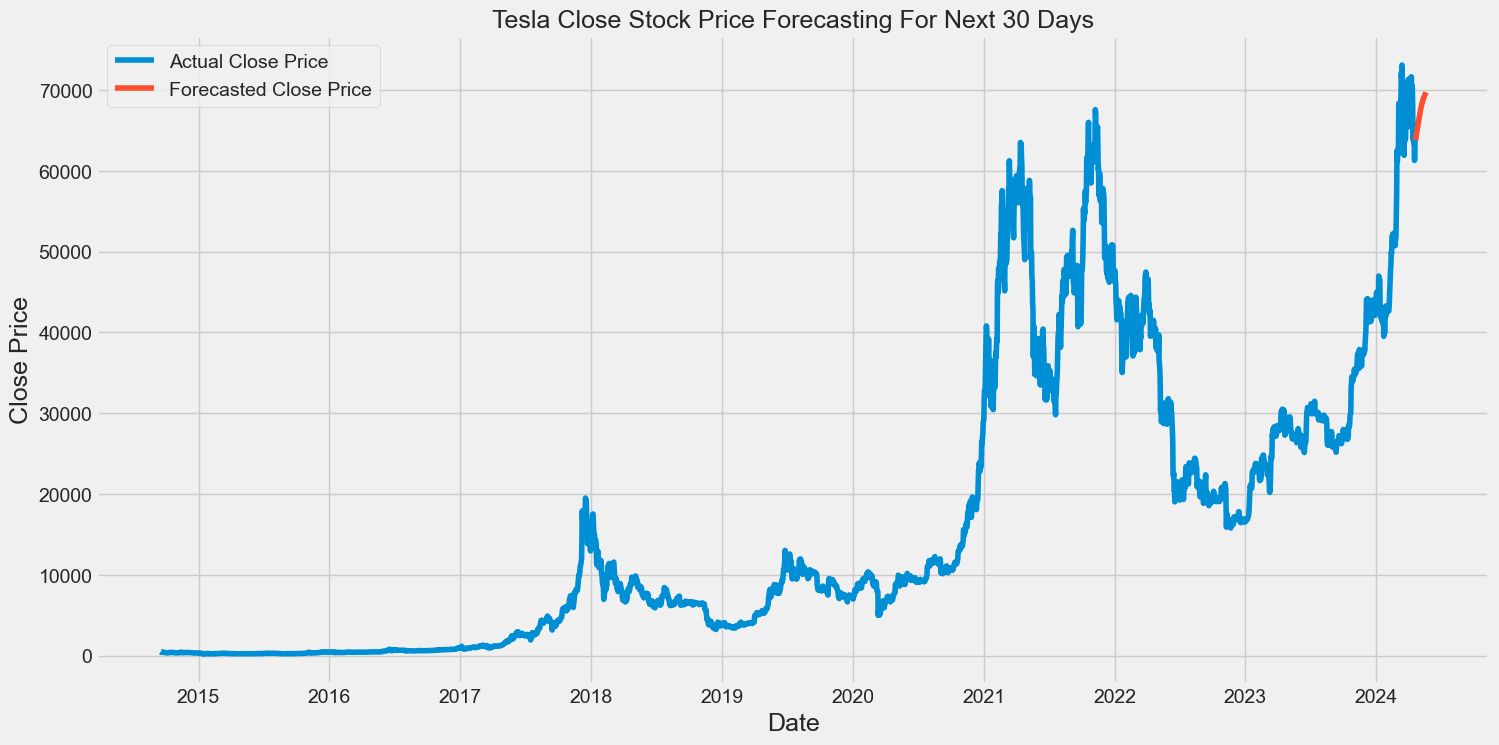

In [34]:
# Plot the forecasted values along with the actual closing prices
plt.figure(figsize=(16, 8))  # Set the figure size for better visualization
plt.title('Tesla Close Stock Price Forecasting For Next 30 Days', fontsize=18)  # Set the title of the plot
plt.xlabel('Date', fontsize=18)  # Set the label for the x-axis
plt.ylabel('Close Price', fontsize=18)  # Set the label for the y-axis
plt.plot(df_day['Close'], label='Actual Close Price')  # Plot the actual closing prices
plt.plot(df_result.set_index('Date')['Forecasted'], label='Forecasted Close Price')  # Plot the forecasted closing prices
plt.legend()  # Show the legend for better interpretation
plt.show()  # Display the plot